In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/NA_fix"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [44]:
source('helpers.R')
source('validation_utils.R')

kaggle.house.loadLibraries()
data <- kaggle.house.loadData()

data$combined %>% 
select(-dataSource) %>% 
filter(!is.na(LotFrontage)) %>% 
mutate(
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) -> df.LotFrontage

df.LotFrontage %>% dim

[1] 2433   81

In [52]:
df <- df.LotFrontage %>% select(LotFrontage.log, LotArea.log, MSSubClass, Neighborhood)


model_maker <- function (data) {
    
    data %>%
    group_by(MSSubClass) %>%
    mutate(MSSubClass.avg = median(LotFrontage.log)) %>%
    group_by(Neighborhood) %>%
    mutate(Neighborhood.avg = median(LotFrontage.log)) %>%
    lm(LotFrontage.log ~ LotArea.log + MSSubClass.avg + Neighborhood.avg, data = .)
}

kaggle.house.validation.do_many_partitions(
    data=df, 
    p=0.6, 
    numrep=200,
    target_var="LotFrontage.log",
    model_maker=model_maker) -> model_index_pairs

models <- model_index_pairs %>% map('model')




Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.avg + 
    Neighborhood.avg, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.01056 -0.09321  0.00605  0.10197  1.12914 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.19407    0.07940 -15.039  < 2e-16 ***
LotArea.log       0.30090    0.01299  23.164  < 2e-16 ***
MSSubClass.avg    0.45987    0.02243  20.500  < 2e-16 ***
Neighborhood.avg  0.17439    0.02155   8.092 9.17e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2045 on 2429 degrees of freedom
Multiple R-squared:  0.6736,	Adjusted R-squared:  0.6732 
F-statistic:  1671 on 3 and 2429 DF,  p-value: < 2.2e-16


[1] 101.6029

term,estimate,std.error,statistic,p.value
(Intercept),-0.7249470,0.10935547,-6.629271,4.734383e-11
LotArea.log,0.5410821,0.01204019,44.939656,1.262624e-277
(Intercept),-0.7394919,0.11052893,-6.690483,3.160293e-11
LotArea.log,0.5424976,0.01217314,44.565122,1.485811e-274
(Intercept),-0.7313529,0.11009110,-6.643161,4.320750e-11
LotArea.log,0.5417399,0.01210951,44.736743,5.812954e-276


,train_score,test_score
2,0.05224169,0.05373814
210,0.05493309,0.04967495
3,0.05452934,0.05028578
4,0.05072911,0.05600218
5,0.05137944,0.05505716
6,0.05868171,0.04422545


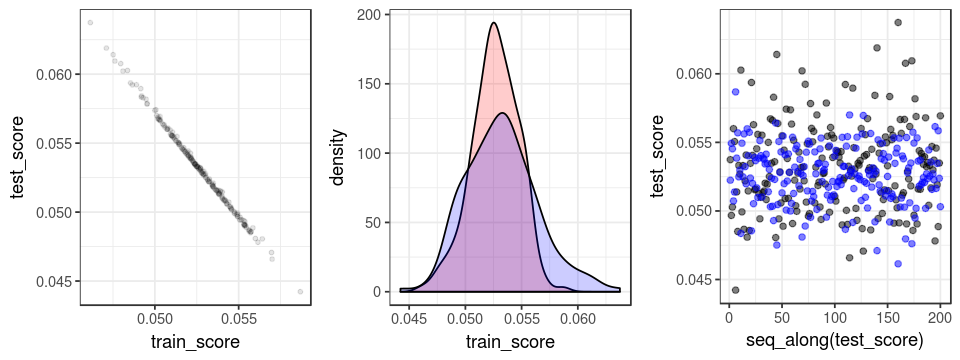

In [40]:
df0 <- df.LotFrontage %>%
select(LotFrontage.log, LotArea.log, MSSubClass, Neighborhood) %>%
group_by(MSSubClass) %>%
mutate(MSSubClass.avg = median(LotFrontage.log)) %>%
group_by(Neighborhood) %>%
mutate(Neighborhood.avg = median(LotFrontage.log))

df0 %>% 
lm(LotFrontage.log ~ LotArea.log + MSSubClass.avg + Neighborhood.avg, data = .) -> model0

model0 %>% summary
sum(model0$residuals ^ 2)

kaggle.house.validation.do_many_partitions(
    data=df0, 
    formula=formula(model0), 
    p=0.6, 
    numrep=200) -> model_index_pairs

tidy <- do.call(rbind, model_index_pairs %>% map('model') %>% map(broom::tidy))
scores <- model_index_pairs %>% kaggle.house.validation.get_scores(df) 

tidy %>% head
scores %>% head

options(repr.plot.width = 8, repr.plot.height = 3)
kaggle.house.validation.plot_scores(scores)


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass.Neighborhood.avg, 
    data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.89818 -0.08450 -0.00215  0.08269  1.20923 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.69227    0.07154  -9.677   <2e-16 ***
LotArea.log                  0.23581    0.01263  18.678   <2e-16 ***
MSSubClass.Neighborhood.avg  0.65670    0.02056  31.944   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.193 on 2430 degrees of freedom
Multiple R-squared:  0.7093,	Adjusted R-squared:  0.709 
F-statistic:  2964 on 2 and 2430 DF,  p-value: < 2.2e-16


[1] 90.495

term,estimate,std.error,statistic,p.value
(Intercept),-0.8986964,0.11417920,-7.870929,6.809438e-15
LotArea.log,0.5607498,0.01258437,44.559240,1.660438e-274
(Intercept),-0.7230235,0.11318951,-6.387726,2.258090e-10
LotArea.log,0.5409541,0.01245655,43.427280,3.344774e-265
(Intercept),-0.7617015,0.10527044,-7.235663,7.455943e-13
LotArea.log,0.5453085,0.01159323,47.036800,9.736577e-295


,train_score,test_score
2,0.05362333,0.05170698
210,0.05353174,0.05179960
3,0.05194206,0.05415497
4,0.05485396,0.04990104
5,0.05294356,0.05265607
6,0.05427936,0.05062226


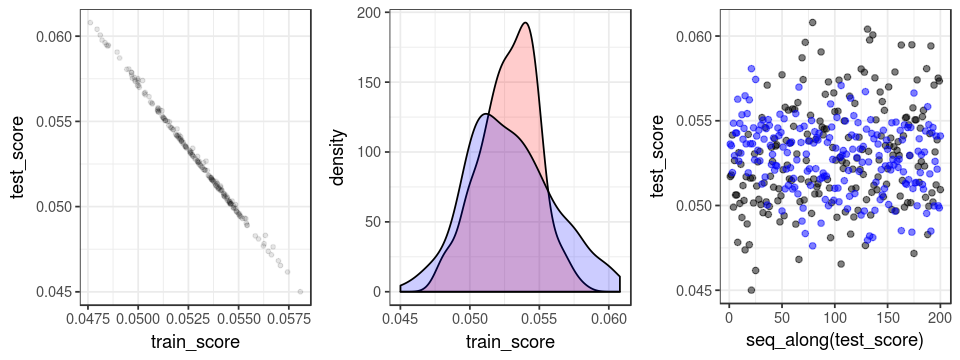

In [41]:
df1 <- df.LotFrontage %>%
select(LotFrontage.log, LotArea.log, MSSubClass, Neighborhood) %>%
group_by(MSSubClass, Neighborhood) %>%
mutate(MSSubClass.Neighborhood.avg = median(LotFrontage.log))

df1 %>% 
lm(LotFrontage.log ~ LotArea.log + MSSubClass.Neighborhood.avg, data = .) -> model1

model1 %>% summary
sum(model1$residuals ^ 2)

kaggle.house.validation.do_many_partitions(
    data=df1, 
    formula=formula(model1), 
    p=0.6, 
    numrep=200) -> model_index_pairs

tidy <- do.call(rbind, model_index_pairs %>% map('model') %>% map(broom::tidy))
scores <- model_index_pairs %>% kaggle.house.validation.get_scores(df) 

tidy %>% head
scores %>% head

options(repr.plot.width = 8, repr.plot.height = 3)
kaggle.house.validation.plot_scores(scores)